In [1]:
from nptdms import TdmsFile
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
from HyperspectralAnalysis import HyperspectralAnalysis 
hyps = HyperspectralAnalysis()

### Read in data files


In [3]:
path_int = '../Mg Analyses/241221/nps_in_glycerol/mg110_glyc_33.tdms'
pathbc = '../Mg Analyses/241221/nps_in_glycerol/mg110_glyc_WC34.tdms'
pathdc = '../Mg Analyses/241221/nps_in_glycerol/mg110_glyc_DC35.tdms'
path_positions = '../Mg Analyses/241221/nps_in_glycerol/mg110_glyc_33/positions.txt'
wavei = 145 # index of starting wavelength 
wavef = 670 # index of end wavelength



# path_int = '../Training Data and Analysis/all_training_data_folders/240920/au77_aft_28.tdms'
# pathbc = '../Training Data and Analysis/all_training_data_folders/240920/au77_WC24.tdms'
# pathdc = '../Training Data and Analysis/all_training_data_folders/240920/au77_DC25.tdms'
# path_positions = '../Training Data and Analysis/all_training_data_folders/240920/au77_aft_28/positions.txt'
# wavei = 205 # index of starting wavelength 
# wavef = 670-235 # index of end wavelength




pixel_params, wave_raw, inten_raw = hyps.read_tdms(tdms_file=TdmsFile.read(path_int), datalen=670)
_, w1, dc_raw =     hyps.read_tdms(tdms_file=TdmsFile.read(pathdc), datalen=1340)
_, w2, bc_raw =    hyps.read_tdms(tdms_file=TdmsFile.read(pathbc),  datalen=1340)

### Process the data


In [4]:
wc_minus_dc = hyps.process_wcdc(dc_raw=dc_raw, 
                         bc_raw=bc_raw,
                         pixel_params=pixel_params)

bk_global, indices = hyps.back_global(I_raw=inten_raw,
                                 percent=0.1)

DFS_backglob = hyps.calc_DFS(inten_raw=inten_raw, 
                             wc_minus_dc=wc_minus_dc, 
                             back=bk_global,
                             )


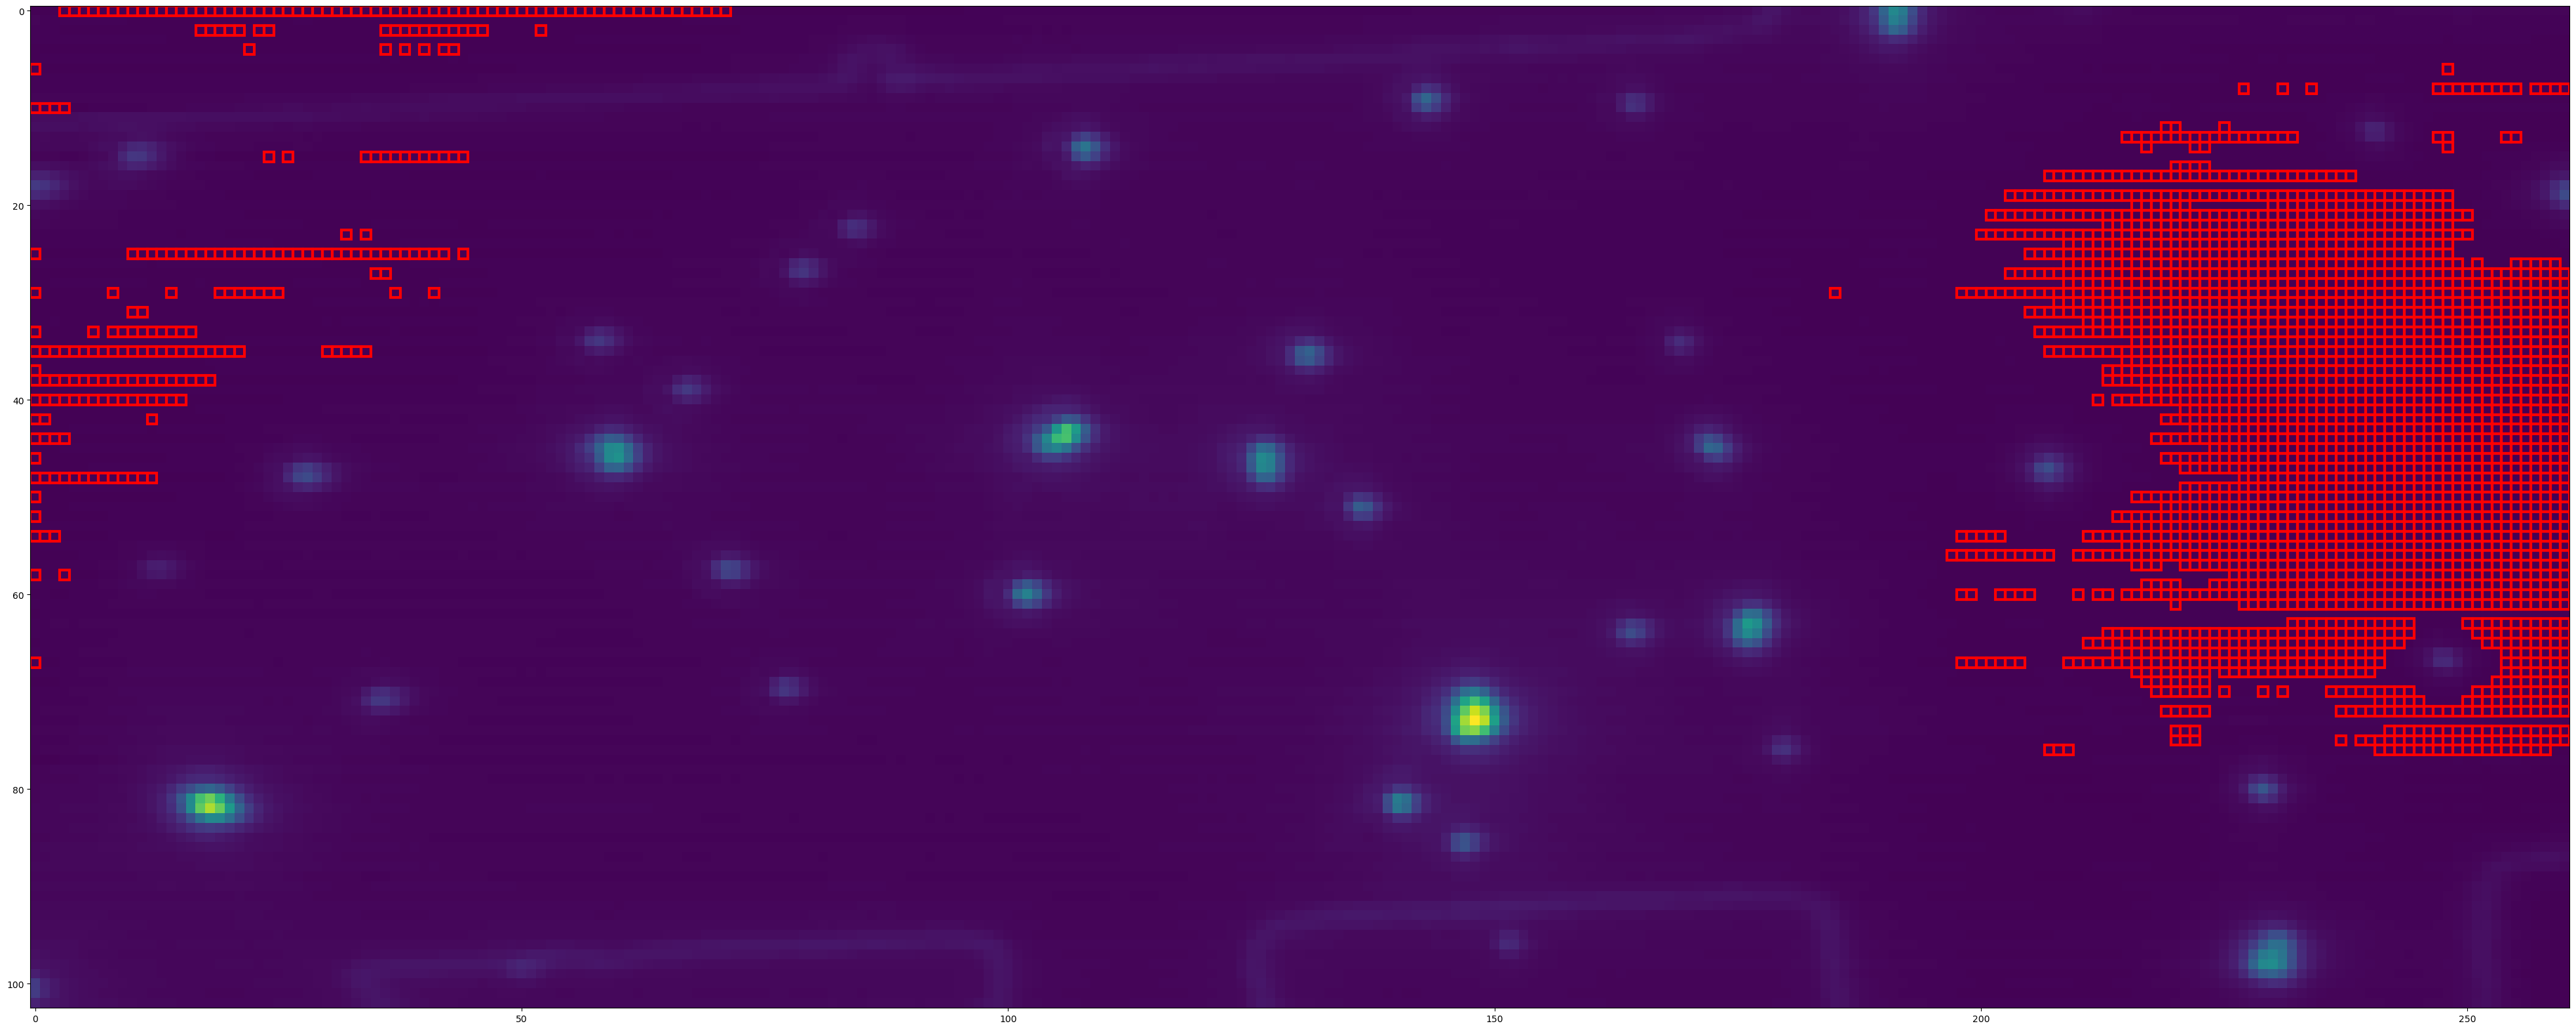

In [5]:
## Find which pixels are being averaged over
fig, ax = plt.subplots(1,1, figsize=[50,20])
ax.imshow(np.sum(inten_raw, 2))


def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect


for i in range(len(indices[0])):
    highlight_cell(indices[1][i],indices[0][i], color="red", linewidth=3)


    

### Plot around a NP, with and without background corrections

Text(0.5, 1.0, 'Raw inten.')

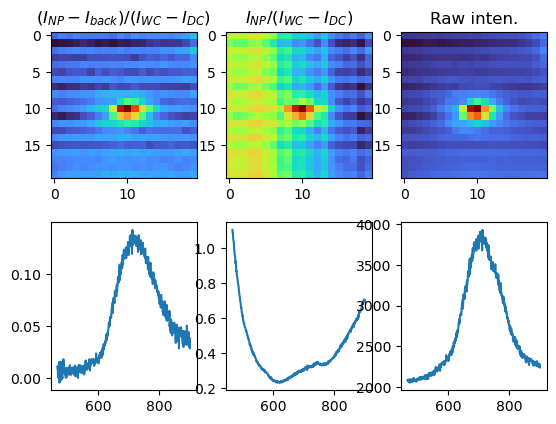

In [6]:
npi = 0 # NP index
wind = 10 # window for plotting around NP
wavei = 100 # index of starting wavelength 
wavef = 670 # index of end wavelength


positions = np.loadtxt(path_positions)
xi = int(positions[npi,0])-1
yi = int(positions[npi,1])-1

fig, ax = plt.subplots(2,3)

DFS_allpixels_bglob_sumwave = np.sum(DFS_backglob,2)
ax[0,0].imshow(DFS_allpixels_bglob_sumwave[xi-wind:xi+wind, yi-wind:yi+wind,], cmap='turbo')
ax[1,0].plot(wave_raw[wavei:wavef], DFS_backglob[xi,yi,wavei:wavef])
ax[0,0].set_title('$(I_{NP} - I_{back}) / (I_{WC} - I_{DC}$)')


DFS_allpixels_noback = inten_raw / wc_minus_dc
DFS_allpixels_noback_sumwave = np.sum(DFS_allpixels_noback, 2)
ax[0,1].imshow(DFS_allpixels_noback_sumwave[xi-wind:xi+wind, yi-wind:yi+wind], cmap='turbo')
ax[1,1].plot(wave_raw[wavei:wavef], DFS_allpixels_noback[xi,yi,wavei:wavef])
ax[0,1].set_title('$I_{NP} / (I_{WC} - I_{DC}$)')

Iraw_allpixels_sumwave = np.sum(inten_raw,2)
ax[0,2].imshow(Iraw_allpixels_sumwave[xi-wind:xi+wind, yi-wind:yi+wind], cmap='turbo')
ax[1,2].plot(wave_raw[wavei:wavef], inten_raw[xi,yi,wavei:wavef])
ax[0,2].set_title('Raw inten.')



### Check fitting for one NP at one wavelength

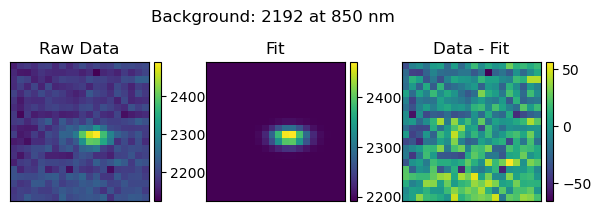

In [7]:
npi = 0
xi = int(positions[npi, 0]) - 1
yi = int(positions[npi, 1]) - 1

wi = 240+6*60# which wavelength to look at 
inten_raw_wind, fit_intenraw, popt = hyps.fitNP_eachwave(specfin=inten_raw,
                                         waveidx=(wi),
                                         xi=xi,
                                         yi=yi)
# 945.45831299
fig, ax = plt.subplots(1,3,figsize=[7,3])
im_d = ax[0].imshow(inten_raw_wind)#, vmin=1000, vmax=3000)
im_f = ax[1].imshow(fit_intenraw)#, vmin=1000, vmax=3000)
im_r = ax[2].imshow(inten_raw_wind-fit_intenraw)#, vmin=1000, vmax=3000)
# print('Background:', int(np.round(popt[-1]*1E3,0)), 'at', int(np.round(wave_raw[wi])), 'nm')
ax[0].set_title('Raw Data')
ax[1].set_title('Fit')
ax[2].set_title('Data - Fit')

im = [im_d, im_f, im_r]
for i in range(3):
    ax[i].set_xticks([]); ax[i].set_yticks([])
    divider = make_axes_locatable(ax[i])
    cax_ij = divider.append_axes("right", size="5%", pad=0.05)
    cbarij = plt.colorbar(im[i], cax=cax_ij)

fig.suptitle('Background: '+ str(int(np.round(popt[-1]*1E3,0)))+ ' at '+str(int(np.round(wave_raw[wi])))+ ' nm', y=.9)
fig.subplots_adjust(wspace=.3)

In [8]:
numPart = len(positions)
numWaves = wavef-wavei 
background = hyps.fit_all_NPs_eachwave(inten_raw=inten_raw,
                                       positions=positions,
                                       background=np.zeros((numPart, numWaves)),
                                       numPart=numPart,
                                       numWaves=numWaves,
                                       wavei=wavei,
                                       wavef=wavef)


In [9]:
print(background.shape)

(15, 570)


### Plot spectra for all NPs.
Compare global background subtraction and local background subtraction techniques.

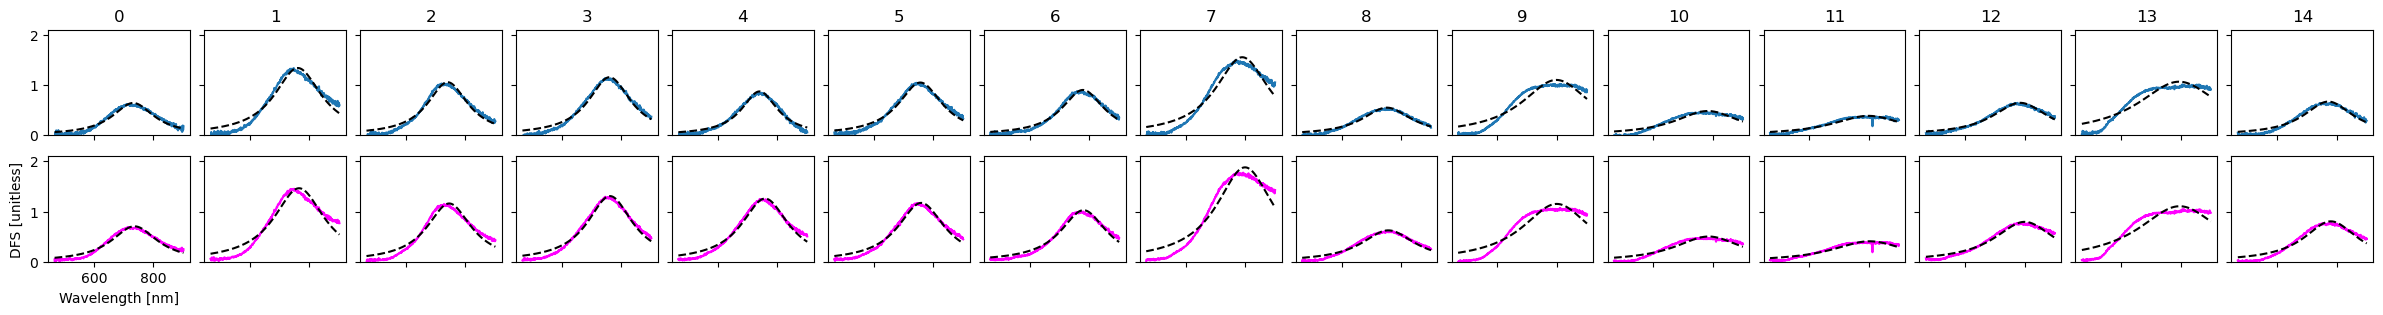

In [10]:
numPlot = numPart

fig, ax = plt.subplots(2,numPlot, figsize=[numPlot*2, 4])#,sharex=True, sharey=True)

wave = wave_raw[wavei:wavef]

gam_global = np.zeros(numPart)
eres_global = np.zeros(numPart)

gam_local = np.zeros(numPart)
eres_local = np.zeros(numPart)


for npi in range(0,numPlot):
    idx = npi
#     idx = 0
    xi = int(positions[npi,0])-1
    yi = int(positions[npi,1])-1
    
    DFS_local = hyps.calc_DFS_localback(inten_raw=inten_raw,
                                        wc_minus_dc=wc_minus_dc,
                                        background=background,
                                        npi=npi,
                                        xi=xi,
                                        yi=yi,
                                        wavei=wavei,
                                        wavef=wavef)
    
    ax[0,idx].plot(wave, DFS_local)
    fit_local, popt_local = hyps.fit_spectrum(wave, DFS_local)
    ax[0,idx].plot(wave, fit_local, color='k', linestyle='--', label=int(popt_local[1]))
    gam_local[npi] = popt_local[1]; eres_local[npi] = popt_local[2]
    
    DFS_global = hyps.avg3pixels(M=DFS_backglob, xi=xi, yi=yi)

    ax[1,idx].plot(wave, DFS_global[wavei:wavef], color='magenta', label='Fit Background')
    fit_global, popt_global = hyps.fit_spectrum(wave, DFS_global[wavei:wavef])
    ax[1,idx].plot(wave, fit_global, color='k', linestyle='--')
    gam_global[npi] = popt_global[1]; eres_global[npi] = popt_global[2]

    ax[0, idx].set_title(npi)
    ax[0,idx].set_ylim([0,2.1]);
    ax[1,idx].set_ylim([0,2.1]);

#     ax[0,idx].set_xticks([500,900])
#     ax[1,idx].set_xticks([500,900])
#     ax[1,0].set_xticklabels([500,900])
#     ax[0,idx].set_xlim([500,900]);
#     ax[1,idx].set_xlim([500,900]);

    ax[0,0].set_xticklabels([])
    
    if idx > 0:
        ax[0,idx].set_xticklabels([])
        ax[1,idx].set_xticklabels([])
        ax[0,idx].set_yticklabels([])
        ax[1,idx].set_yticklabels([])


# ax[0,0].set_xlim([600,780]);
ax[1,0].set_ylim([0,2.1]);
ax[1,1].set_ylim([0,2.1]);

ax[1,0].set_xlabel('Wavelength [nm]')
# ax[1,1].set_xlabel('Wavelength [nm]')

ax[1,0].set_ylabel('DFS [unitless]')
fig.subplots_adjust(wspace=.1, bottom=.3)
# fig.savefig('auNRs_subset_allspectra.png', dpi=600)



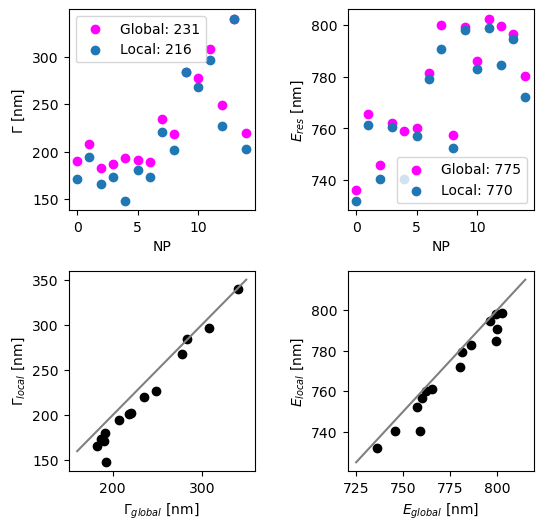

In [11]:
fig, ax = plt.subplots(2,2, figsize=[6,6])


label=str('Global: ')+str(int(np.round(np.mean(gam_global))))
ax[0,0].scatter(np.arange(0,len(positions)), gam_global, label=label, color='magenta')
label=str('Local: ')+str(int(np.round(np.mean(gam_local))))
ax[0,0].scatter(np.arange(0,len(positions)), gam_local, label=label, color='tab:blue')


ax[1,0].scatter(gam_global, gam_local, color='k')
ax[1,0].plot([160,350], [160,350], color='gray')
ax[1,0].set_xlabel('$\Gamma_{global}$ [nm]')
ax[1,0].set_ylabel('$\Gamma_{local}$ [nm]')


label=str('Global: ')+str(int(np.round(np.mean(eres_global))))
ax[0,1].scatter(np.arange(0,len(positions)), eres_global, label=label, color='magenta')
label=str('Local: ')+str(int(np.round(np.mean(eres_local))))
ax[0,1].scatter(np.arange(0,len(positions)), eres_local, label=label, color='tab:blue')

ax[1,1].scatter(eres_global, eres_local, color='k')
ax[1,1].plot([725,815], [725,815], color='gray')
ax[1,1].set_xlabel('$E_{global}$ [nm]')
ax[1,1].set_ylabel('$E_{local}$ [nm]')



ax[0,0].set_ylabel('$\Gamma$ [nm]')
ax[0,0].set_xlabel('NP'); ax[0,1].set_xlabel('NP')

ax[0,1].set_ylabel('$E_{res}$ [nm]')

ax[0,0].legend()#frameon=False)
ax[0,1].legend()#frameon=False)

fig.subplots_adjust(wspace=.5, hspace=.3)

894.46484375


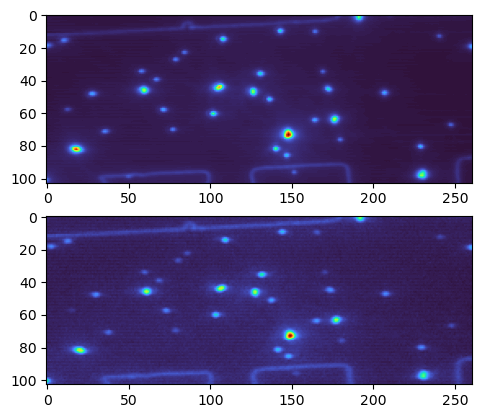

In [12]:
fig, ax = plt.subplots(2,1)
ax[0].imshow(np.sum(inten_raw,2), cmap='turbo')

ax[1].imshow(inten_raw[:,:,-10], cmap='turbo')


print(wave_raw[-10])

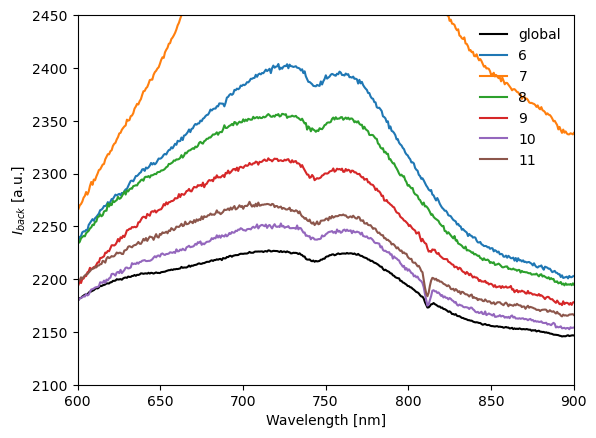

In [13]:

plt.plot(wave_raw, bk_global, color='black', label='global')
for i in range(6,12):
    plt.plot(wave, background[i,:], label=i)
plt.xlim([600, 900])
plt.ylim([2100,2450])
plt.xlabel('Wavelength [nm]')
plt.ylabel('$I_{back}$ [a.u.]')
plt.legend(frameon=False)